In [1]:
#!/usr/bin/env python3
from main.utils.spark_utils import init_spark
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, TimestampType, FloatType, StringType
from pyspark.sql.functions import sum, max, col, pandas_udf, PandasUDFType, lit

from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import date

import time
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = init_spark('multi_forecasting')

In [3]:
# structure of the training data set
train_schema = StructType([
  StructField('date', DateType()),
  StructField('store', IntegerType()),
  StructField('item', IntegerType()),
  StructField('sales', IntegerType())
  ])

# read the training file into a DataFrame
train_df = spark.read.csv(
  '../src/main/resources/kaggle/train.csv',
  header=True,
  schema=train_schema
  )

In [4]:
stores = train_df.select('store').orderBy('store').distinct()

In [5]:
distinct_items = train_df.select('item').distinct().count()
print(f'Available data has {distinct_items} distinct items on stock')

Available data has 50 distinct items on stock


In [6]:
# Top 10 sales per store and item
sale_items_per_store = train_df.groupBy(['store', 'item']).agg(sum('sales').alias('total_sale_items'))\
    .orderBy('total_sale_items', ascending=False)
sale_items_per_store.show(10)

# make the DataFrame available as query temporary view
train_df.createOrReplaceTempView('train')

+-----+----+----------------+
|store|item|total_sale_items|
+-----+----+----------------+
|    2|  28|          205677|
|    2|  15|          205569|
|    2|  18|          197422|
|    8|  15|          197295|
|    2|  13|          197031|
|    8|  28|          196867|
|    8|  18|          189576|
|    8|  13|          189575|
|    2|  25|          188856|
|    2|  45|          188774|
+-----+----+----------------+
only showing top 10 rows



In [7]:
sql_statement = '''
  SELECT
    store,
    item,
    CAST(date as timestamp) as ds,
    SUM(sales) as y
  FROM train
  GROUP BY store, item, ds
  ORDER BY store, item, ds
  '''

# assemble DataSet in Pandas DataFrame
store_item_history_df = spark.sql(sql_statement)\
    .repartition(spark.sparkContext.defaultParallelism, ['store', 'item'])

In [8]:
store_item_history_df.cache()

DataFrame[store: int, item: int, ds: timestamp, y: bigint]

In [9]:
store_item_history_df.show()

+-----+----+-------------------+---+
|store|item|                 ds|  y|
+-----+----+-------------------+---+
|    1|   5|2013-01-01 00:00:00| 11|
|    1|   5|2013-01-02 00:00:00|  6|
|    1|   5|2013-01-03 00:00:00|  8|
|    1|   5|2013-01-04 00:00:00|  9|
|    1|   5|2013-01-05 00:00:00|  8|
|    1|   5|2013-01-06 00:00:00| 13|
|    1|   5|2013-01-07 00:00:00| 11|
|    1|   5|2013-01-08 00:00:00| 10|
|    1|   5|2013-01-09 00:00:00|  7|
|    1|   5|2013-01-10 00:00:00|  8|
|    1|   5|2013-01-11 00:00:00| 10|
|    1|   5|2013-01-12 00:00:00|  8|
|    1|   5|2013-01-13 00:00:00| 11|
|    1|   5|2013-01-14 00:00:00|  5|
|    1|   5|2013-01-15 00:00:00| 10|
|    1|   5|2013-01-16 00:00:00|  6|
|    1|   5|2013-01-17 00:00:00|  7|
|    1|   5|2013-01-18 00:00:00| 10|
|    1|   5|2013-01-19 00:00:00|  8|
|    1|   5|2013-01-20 00:00:00|  9|
+-----+----+-------------------+---+
only showing top 20 rows



In [10]:
history_pd = store_item_history_df.toPandas()
print(history_pd.describe())

# drop any missing records
history_pd = history_pd.dropna()
print(history_pd.head())
print(history_pd.dtypes)

               store           item              y
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000
   store  item         ds   y
0      1     5 2013-01-01  11
1      1     5 2013-01-02   6
2      1     5 2013-01-03   8
3      1     5 2013-01-04   9
4      1     5 2013-01-05   8
store             int32
item              int32
ds       datetime64[ns]
y                 int64
dtype: object


In [11]:
# history_pd["ds"]  = pd.to_datetime(history_pd["ds"])

In [12]:
print(history_pd.dtypes)

store             int32
item              int32
ds       datetime64[ns]
y                 int64
dtype: object


In [13]:
history_pd.head()

,store,item,ds,y
0,1,5,2013-01-01,11
1,1,5,2013-01-02,6
2,1,5,2013-01-03,8
3,1,5,2013-01-04,9
4,1,5,2013-01-05,8


In [14]:
# Pivot data to represent each store
stores_to_pivot = list(stores.toPandas()['store'])

store_item_history_pivot = store_item_history_df.groupBy(['item', 'ds']) \
    .pivot('store', stores_to_pivot) \
    .agg(sum("y").alias("total_sale_items"))

store_item_history_pivot.show()
# |item| ds|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10|

+----+-------------------+---+---+---+---+---+---+---+---+---+---+
|item|                 ds|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10|
+----+-------------------+---+---+---+---+---+---+---+---+---+---+
|   5|2013-02-12 00:00:00| 13| 16| 13|  9|  7|  5|  7| 10| 12| 15|
|   5|2013-03-31 00:00:00| 15| 26| 17| 17|  7|  8|  4| 18| 20| 19|
|  16|2013-02-15 00:00:00| 17| 34| 28| 13| 13| 17| 12| 23| 18| 19|
|  28|2013-06-08 00:00:00| 88|105|108| 85| 71| 82| 80|117|103| 86|
|  30|2013-02-08 00:00:00| 36| 36| 30| 28| 27| 25| 17| 37| 22| 31|
|  30|2013-03-24 00:00:00| 34| 33| 46| 33| 28| 27| 17| 49| 33| 38|
|  37|2013-03-07 00:00:00| 22| 27| 25| 21| 14| 14| 16| 18| 28| 37|
|  37|2013-06-22 00:00:00| 36| 44| 44| 31| 30| 26| 23| 40| 33| 43|
|  42|2013-07-08 00:00:00| 29| 44| 39| 25| 24| 30| 24| 44| 32| 36|
|  49|2013-06-04 00:00:00| 26| 30| 35| 31| 20| 14| 14| 34| 35| 28|
|  10|2013-04-18 00:00:00| 60| 74| 63| 60| 42| 30| 44| 85| 61| 79|
|  10|2013-06-07 00:00:00| 87| 91| 92| 92| 72| 62| 50| 75| 76|

In [15]:
store_item_history_pivot.printSchema()

root
 |-- item: integer (nullable = true)
 |-- ds: timestamp (nullable = true)
 |-- 1: long (nullable = true)
 |-- 2: long (nullable = true)
 |-- 3: long (nullable = true)
 |-- 4: long (nullable = true)
 |-- 5: long (nullable = true)
 |-- 6: long (nullable = true)
 |-- 7: long (nullable = true)
 |-- 8: long (nullable = true)
 |-- 9: long (nullable = true)
 |-- 10: long (nullable = true)



In [16]:
store_item_history_pivot_pd = store_item_history_pivot.toPandas()

In [17]:
store_item_history_pivot_pd.dtypes

item             int32
ds      datetime64[ns]
1                int64
2                int64
3                int64
4                int64
5                int64
6                int64
7                int64
8                int64
9                int64
10               int64
dtype: object

In [18]:
# store_item_history_pivot_pd["ds"]  = pd.to_datetime(store_item_history_pivot_pd["ds"])

In [19]:
store_item_history_pivot_pd.head()

,item,ds,1,2,3,4,5,6,7,8,9,10
0,5,2013-02-12,13,16,13,9,7,5,7,10,12,15
1,5,2013-03-31,15,26,17,17,7,8,4,18,20,19
2,16,2013-02-15,17,34,28,13,13,17,12,23,18,19
3,28,2013-06-08,88,105,108,85,71,82,80,117,103,86
4,30,2013-02-08,36,36,30,28,27,25,17,37,22,31


In [20]:
# x = store_item_history_pivot_pd.select([c for c in store_item_history_pivot_pd.columns if c not in to_drop])

store_item_history_plot = store_item_history_pivot_pd.drop('item', axis=1)
print(store_item_history_plot.head())

          ds   1    2    3   4   5   6   7    8    9  10
0 2013-02-12  13   16   13   9   7   5   7   10   12  15
1 2013-03-31  15   26   17  17   7   8   4   18   20  19
2 2013-02-15  17   34   28  13  13  17  12   23   18  19
3 2013-06-08  88  105  108  85  71  82  80  117  103  86
4 2013-02-08  36   36   30  28  27  25  17   37   22  31


In [21]:
print(store_item_history_pivot_pd[store_item_history_pivot_pd['ds'].isin(['2013-03-27', '2013-01-08'])].head(5))

      item         ds   1   2   3   4   5   6   7   8   9  10
1873    16 2013-01-08  11  11  10   7  15   6   8   6  16  15
1879    29 2013-01-08  35  51  52  44  20  24  22  48  37  40
2346    45 2013-03-27  40  62  57  54  41  43  34  66  65  56
3273    35 2013-01-08  34  50  46  29  27  20  20  33  31  44
5055    49 2013-01-08  13  29  18  15   7  16   7  13  14  14


In [22]:
history_pd_pivoted = history_pd.pivot_table(index='ds', columns='store', values='y', aggfunc='sum')
print(history_pd_pivoted.head())

# history_pd_pivoted.plot()
# plt.show()

store         1     2     3     4     5     6     7     8     9     10
ds                                                                    
2013-01-01  1316  1742  1588  1423  1032  1099   964  1628  1383  1521
2013-01-02  1264  1808  1538  1432   997  1023   944  1687  1455  1530
2013-01-03  1305  1887  1635  1534  1130  1149   966  1736  1492  1654
2013-01-04  1452  1983  1741  1685  1258  1201  1040  1966  1612  1739
2013-01-05  1499  2087  1887  1649  1154  1286  1131  2005  1698  1841


In [23]:
# structure of the dataset returned by the function

result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('y', FloatType()),
  StructField('yhat_lower', FloatType()),
  StructField('yhat_upper', FloatType()),
  StructField('trend_lower', FloatType()),
  StructField('trend_upper', FloatType()),
  StructField('multiplicative_terms', FloatType()),
  StructField('multiplicative_terms_lower', FloatType()),
  StructField('multiplicative_terms_upper', FloatType()),
  StructField('weekly', FloatType()),
  StructField('weekly_lower', FloatType()),
  StructField('weekly_upper', FloatType()),
  StructField('yearly', FloatType()),
  StructField('yearly_lower', FloatType()),
  StructField('yearly_upper', FloatType()),
  StructField('daily', FloatType()),
  StructField('daily_lower', FloatType()),
  StructField('daily_upper', FloatType()),
  StructField('additive_terms', FloatType()),
  StructField('additive_terms_lower', FloatType()),
  StructField('additive_terms_upper', FloatType()),
  StructField('yhat', FloatType())
  ])

In [24]:
result_schema =StructType([
  StructField('ds', TimestampType()),
  StructField('store',IntegerType()),
  StructField('item',IntegerType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

In [25]:
# forecast function
@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def get_forecast(history_pd):
    import shutil
    # import mlflow
    # Our first step is to assemble the historical DataSet on which we will train the model
    # instantiate the model and set parameters
    model = Prophet(
        interval_width=0.95,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
        #,holidays=holidays_pd
    )

      
    # train model
    model.fit(history_pd)
  
    # save models for potential later use
    # model_path = '/timeseries/{0}'.format('store')
    # shutil.rmtree(model_path, ignore_errors=True)
    # mlflow.sklearn.save_model(model, model_path)

    # make forecast dataframe
    # define a dataset including both historical dates & 90-days beyond the last available date
    future_pd = model.make_future_dataframe(
        periods=90,
        freq='d',
        include_history=True
    )

    # Predict over the dataset forecast
    forecast_pd = model.predict(future_pd)
    
    # ASSEMBLE EXPECTED RESULT SET
    
    # get relevant fields from forecast
    f_pd = forecast_pd[['ds','yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
    # get relevant fields from history
    h_pd = history_pd[['ds','store','item','y']].set_index('ds')
  
    # join history and forecast
    results_pd = f_pd.join( h_pd, how='left' )
    results_pd.reset_index(level=0, inplace=True)
    
    # get store & item from incoming data set
    results_pd['store'] = history_pd['store'].iloc[0]
    results_pd['item'] = history_pd['item'].iloc[0]
    # --------------------------------------
    
    # return expected dataset
    return results_pd[['ds', 'store', 'item', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [31]:
time_start_all = time.time()

In [32]:
from pyspark.sql.functions import current_date
import pyarrow as pa 

results = (
  store_item_history_df
    .groupBy('store', 'item')
    .apply(get_forecast)
    .withColumn('training_date', lit(date.today()))
    ).cache()

In [33]:
results.createOrReplaceTempView('new_forecasts')

In [34]:
# Plot sales per year
sql_new_forecasts = '''
 select 
  ds as date,
  store,
  item,
  y as sales,
  yhat as sales_predicted,
  yhat_upper as sales_predicted_upper,
  yhat_lower as sales_predicted_lower,
  training_date
from new_forecasts
  '''

In [35]:
results.write.parquet('../src/main/resources/kaggle/output/forecasted_sales')

In [36]:
time_finish_all = time.time()
print(f'Computed time at pandas_udf was : {time_finish_all - time_start_all} seconds')


Computed time at pandas_udf was : 1025.7375407218933 seconds


In [37]:
time_start_all = time.time()
sql_new_forecasts = spark.sql(sql_new_forecasts).toPandas()
# drop any missing records
sql_new_forecasts = sql_new_forecasts.dropna()
time_finish_all = time.time()
print(f'Computed time at toPandas conversion was : {time_finish_all - time_start_all} seconds')

Computed time at toPandas conversion was : 112.64919018745422 seconds


In [38]:
print(sql_new_forecasts.head())

        date  store  item  sales  sales_predicted  sales_predicted_upper  \
0 2013-01-01      1     5   11.0         8.078590              16.326565   
1 2013-01-02      1     5    6.0         8.365060              16.151966   
2 2013-01-03      1     5    8.0         9.529001              17.453157   
3 2013-01-04      1     5    9.0         9.800947              17.835989   
4 2013-01-05      1     5    8.0        10.867021              18.828100   

   sales_predicted_lower training_date  
0               0.161641    2020-05-18  
1               0.475921    2020-05-18  
2               1.729006    2020-05-18  
3               2.206596    2020-05-18  
4               2.773755    2020-05-18  


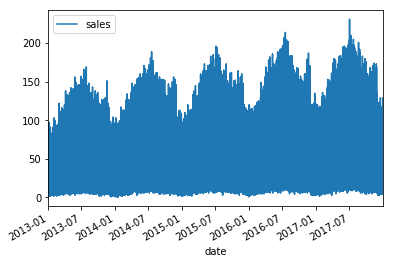

In [39]:
sql_new_forecasts.plot(x='date', y='sales')

In [ ]:
# Generate evaluation metrics for each store-item forecast:
# TODO: new udf_function, save results and interpret errors estimation.